In [88]:
import itertools
import re
import numpy as np
from tqdm.notebook import tqdm
from tabDatabase import *
import matplotlib.pyplot as plt
import pandas as pd
import json
from sqlalchemy import Connection
%load_ext line_profiler

total_entries = 615613
caselist_total = 338521
metadata.create_all(tabEngine)
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 20)
tqdm.pandas()

# Find Team Names

In [17]:
from collections import Counter, defaultdict

In [18]:
def getSections(entry_name: str) -> list[str]:
    if ' - ' in entry_name and ' and ' in entry_name: # Some were formatted like this before 2015-2016 season
        entry_name = entry_name.split(' - ')[1]
    sections = re.split(r', | & | and ', entry_name)
    return [s.strip() for s in sections if s.strip()] # Filter out empty and trim

In [19]:
getShortName = lambda s: re.sub(r'[^a-zA-Z]', '', s)[0:2].capitalize()
def parseTeamName(entry_name: str) -> tuple[str, str]:
    sections = getSections(entry_name)
    if len(sections) >= 2:
        sections = sorted(sections)
        return '&'.join([getShortName(s) for s in sections]), ' & '.join(sections)
    else:
        return ' '.join([getShortName(s) for s in sections[0].split(' ')]), sections[0]

In [20]:
with tabEngine.begin() as conn:
    team_entries = conn.execute(text("""
        select t.id as team_id, t.num_debaters, e.*, t2.season from entry e
            join team t on e.team = t.id
            join event e2 on e.event = e2.id
            join category c on e2.category = c.id
            join tournament t2 on c.tournament = t2.id
            where ((t.num_debaters = 1 and e.name regexp '[a-zA-Z\-'']+ [a-zA-Z\-'']+') or
                  (t.num_debaters >= 2 and e.name regexp '([a-zA-Z\-''. ]+, )*[a-zA-Z\-''. ]+ & [a-zA-Z\-''. ]+'))
                  and t2.season >= 2013;
    """))
    rows = list(tqdm(team_entries.mappings(), total=544143))

  0%|          | 0/544143 [00:00<?, ?it/s]

In [21]:
team_code_sets: defaultdict[str, set] = defaultdict(set)
team_name_sets: defaultdict[str, set] = defaultdict(set)
for row in tqdm(rows):
    team_short_name, team_full_name = parseTeamName(row['name'])
    if team_short_name: team_short_name += str(row['season'])
    if team_full_name: team_full_name += str(row['season'])

    team_code_sets[team_short_name].add(row['team_id'])
    team_name_sets[team_full_name].add(row['team_id'])

  0%|          | 0/544143 [00:00<?, ?it/s]

# Match to caselist

- Direct
    - Name from open source
    - Judge names
    - Opponent codes
    - Side+num
    - Only with name/initials
- Indirect
    - school
    - only name/initials with other matches removed

In [109]:
caselist_data = pd.read_feather('./data/caselist_data.feather')
caselist_team_data = caselist_data.drop_duplicates('teamId').set_index('teamId')
caselist_data_by_team = caselist_data.set_index(['teamId', 'roundId'])

In [113]:
from typing_extensions import Self

sort_str = lambda s: ''.join(sorted(s))
opponent_codes_stmt = text("""
        select distinct any_ballot.section, opponent_entry.short_name from team
            join entry team_entry on team.id = team_entry.team
            join ballot team_ballot on team_entry.id = team_ballot.entry
            join ballot any_ballot on team_ballot.section = any_ballot.section
            join entry opponent_entry on opponent_entry.id = any_ballot.entry
            where team.id = :team_id and opponent_entry.id != team_entry.id and opponent_entry.short_name is not null;
""")

class CaselistTeam:
    def __init__(self, caselist_id: int, rounds: pd.DataFrame = None):
        self.caselist_id = caselist_id
        try:
            self.rounds = rounds if rounds is not None else caselist_data_by_team.loc[caselist_id]
        except KeyError:
            raise ValueError(f"no rounds for the caselist team id {caselist_id}")

        self.team_data = self.rounds.iloc[0]
        self.caselist_judges = self.rounds.judge.dropna().str.lower()
        self.caselist_single_judges = self.caselist_judges[self.caselist_judges.str.fullmatch(r'\w+ \w+')]
        opponents = self.rounds.opponent.dropna()
        self.caselist_opponent_codes = opponents[opponents.str.match(r'.*\s[a-zA-Z]{2}$')].str[-2:].str.upper()
        # Sort codes for two-person teams
        if self.team_data.teamSize > 1: self.caselist_opponent_codes = self.caselist_opponent_codes.apply(sort_str)
        self.candidate_ids = self.find_team_ids()

        self.total_rounds = len(self.rounds)
        self.total_judges = len(self.caselist_single_judges)
        self.total_opponents = len(self.caselist_opponent_codes)

        self.judge_matches: dict[int, int] = {}
        self.opponent_matches: dict[int, int] = {}

    def find_team_ids(self) -> set[int] | None:
        if self.team_data.teamSize == 2:
            if self.team_data.debater2Last is None: return None
            names = sorted((self.team_data.debater1Last[0:2], self.team_data.debater2Last[0:2]))
            team_code = '&'.join(names) + str(self.team_data.year)
        else:
            team_code = f"{self.team_data.debater1First[0:2]} {self.team_data.debater1Last[0:2]}{self.team_data.year}"
        return team_code_sets[team_code]

    def find_judge_matches(self, tabroom_connection: Connection) -> dict[int, int]:
        match_data = {}
        judge_q = ballot_table\
            .join(judge_table, ballot_table.c.judge == judge_table.c.id)\
            .join(entry_table, ballot_table.c.entry == entry_table.c.id)\
            .select().where(entry_table.c.team.in_(self.candidate_ids)).order_by(entry_table.c.team)

        for tabroom_team_id, ballots in itertools.groupby(tabroom_connection.execute(judge_q).mappings(), lambda x: x['team']):
            ballots = list(ballots)
            tab_single_judges = [
                re.sub(r'[^\s\w]', '', f'{ballots[0]["first"]} {ballots[0]["last"]}'.lower()) for ballots in
                (list(ballots) for _, ballots in itertools.groupby(ballots, lambda x: x['section']))
                if len(ballots) == 1
            ]
            match_data[tabroom_team_id] = sum(judge in tab_single_judges for judge in self.caselist_single_judges)
        return match_data

    def find_opponent_matches(self, tabroom_connection: Connection) -> dict[int, int]:
        match_data = {}
        for tabroom_team_id in self.candidate_ids:
            tabroom_opponents = [
                r['short_name']
                for r in tabroom_connection.execute(opponent_codes_stmt.bindparams(team_id=tabroom_team_id)).mappings()
            ]
            print(tabroom_team_id, tabroom_opponents)
            match_data[tabroom_team_id] = sum(opponent in tabroom_opponents for opponent in self.caselist_opponent_codes)
        return match_data

    def match(self, tabroom_connection: Connection) -> Self:
        self.candidate_ids = self.find_team_ids()
        if not self.candidate_ids: return self

        self.judge_matches = self.find_judge_matches(tabroom_connection)
        self.opponent_matches = self.find_opponent_matches(tabroom_connection)
        return self

    @property
    def only(self) -> bool: return len(self.candidate_ids) == 1 if self.candidate_ids else False
    @property
    def only_id(self) -> int | None: return list(self.candidate_ids)[0] if self.only else None

    def to_json(self) -> dict:
        return {
            'caselist_id': self.caselist_id,
            'total_rounds': self.total_rounds,
            'total_judges': self.total_judges,
            'total_opponents': self.total_opponents,
            'judge_matches': self.judge_matches,
            'opponent_matches':self.total_opponents,
            'only': self.only,
            'only_id': self.only_id,
        }

    @staticmethod
    def from_json(data) -> 'CaselistTeam':
        team = CaselistTeam(data['caselist_id'])
        team.judge_matches = data['judge_matches']
        team.opponent_matches = data['opponent_matches']
        return team


In [38]:
caselist_tab_map: dict[int, CaselistTeam] = {}

with tabEngine.begin() as conn:
    for teamId, rounds in tqdm(caselist_data.groupby('teamId')):
        caselist_tab_map[teamId] = CaselistTeam(teamId, rounds).match(conn)

  0%|          | 0/25504 [00:00<?, ?it/s]

In [132]:
with open('./data/caselist_tab_judge_info.json', 'w') as f:
  json.dump({k: v.to_json() for k, v in caselist_tab_map.items()}, f)

## Analyze matches

In [87]:
with open('./data/caselist_tab_judge_info.json', 'r') as f:
    loaded = list(json.load(f).items())

In [118]:
%lprun -f CaselistTeam.__init__ [CaselistTeam(loaded[i][1]['caselist_id']) for i in range(1000)]

In [133]:
with open('./data/caselist_tab_judge_info.json', 'r') as f:
    caselist_tab_map: dict[int, CaselistTeam] = {int(k): CaselistTeam.from_json(v) for k,v in tqdm(json.load(f).items())}

  0%|          | 0/25504 [00:00<?, ?it/s]

In [137]:
judge_ratio = np.array([
    max(info.judge_matches.values()) / info.total_judges if info.total_judges and info.judge_matches else 0
    for info in caselist_tab_map.values()
])

opponent_ratio = np.array([
    max(info.opponent_matches.values()) / info.total_opponents if info.total_opponents and info.opponent_matches else 0
    for info in caselist_tab_map.values()
])

judge_second_ratio = np.array([
    ([0] + sorted(info.judge_matches.values()))[-2] / info.total_judges
    for info in caselist_tab_map.values()
    if len(info.caselist_single_judges) and info.judge_matches
])

opponent_second_ratio = np.array([
    ([0] + sorted(info.opponent_matches.values()))[-2] / info.total_opponents
    for info in caselist_tab_map.values()
    if info.total_opponents and info.opponent_matches
])
values = list(caselist_tab_map.values())

((0.3917816813048933,
  0.4712986198243413,
  0.004495699765441751,
  0.0362262183997915),
 (0.5850454830614805,
  0.4037013801756587,
  0.01763046544428773,
  0.18106488011283497))

In [138]:
((judge_ratio > 0.5).mean(), (judge_ratio > 0.2).mean(), (judge_second_ratio > 0.5).mean(), (judge_second_ratio > 0.2).mean()), \
    ((opponent_ratio > 0.2).mean(), (opponent_ratio > 0.8).mean(), (opponent_second_ratio > 0.8).mean(), (opponent_second_ratio > 0.2).mean())

((0.3933108531994981,
  0.4717299247176913,
  0.004756629960252818,
  0.036880172020590345),
 (0.6131195106649937,
  0.46608375156838144,
  0.035328003762050315,
  0.2837996708205972))

In [139]:
judge_match = judge_ratio > 0.2
opponent_match = opponent_ratio > 0.75
(judge_match.mean(), opponent_match.mean()), (judge_match + opponent_match).mean(), (judge_match * opponent_match).mean(), (judge_match ^ opponent_match).mean()

((0.4717299247176913, 0.488237139272271),
 0.595788895859473,
 0.3641781681304893,
 0.2316107277289837)

In [147]:
only_match = np.array([info.only for info in caselist_tab_map.values()])
only_match.mean()

0.22710163111668757

In [ ]:
missing = [values[i]['teamId'] for i, found in enumerate(judge_ratio < 0.5) if not found]
missing_data = caselist_data[caselist_data.teamId.isin(missing)]
missing_data[(missing_data.year == 2018) & (missing_data.level == 'hs')]

In [141]:
def plot_gte(nums):
    counts = pd.Series(nums).value_counts()
    sums = np.cumsum(counts.sort_index()[::-1])[::-1]
    plt.plot(sums)
    plt.scatter(sums.index, sums)
    return sums

In [ ]:
np.argmax(judge_ratio * np.array([info['total'] for info in values]))

In [ ]:
plt.hist([judge_ratio, opponent_ratio])

,judge,opponent
0,25504.0,25504.0
1,16113.0,17750.0
2,12905.0,14981.0
3,10717.0,12948.0
4,9372.0,11598.0
...,...,...
165,NaN,5.0
180,NaN,4.0
187,NaN,3.0
192,NaN,2.0


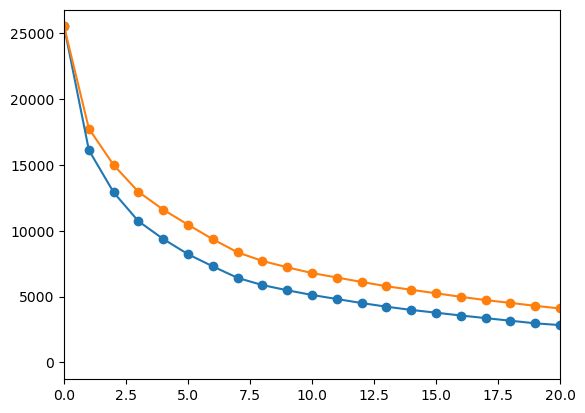

In [144]:
plt.xlim(0, 20)
pd.DataFrame({
    'judge': plot_gte([info.total_judges for info in caselist_tab_map.values()]),
    'opponent': plot_gte([info.total_opponents for info in caselist_tab_map.values()])
})

In [161]:
pd.Series([len(s) for s in team_code_sets.values()]).value_counts() / len(team_code_sets)

1     0.548887
2     0.180096
3     0.082887
4     0.045277
0     0.045062
        ...   
51    0.000008
69    0.000008
80    0.000008
52    0.000008
66    0.000008
Length: 62, dtype: float64

In [145]:
only_missing_ids = [
    (teamId, data.only_id)
    for i, (teamId, data) in enumerate(caselist_tab_map.items())
    if data.only and judge_ratio[i] < 0.2
]

In [35]:
caselist_ids = [data[0] for data in only_missing_ids]
tabroom_ids = [data[1] for data in only_missing_ids]

only_missing_data = caselist_team_data.loc[caselist_ids].teamDisplayName.reset_index()
only_missing_data['tabroomId'] = pd.Series(tabroom_ids)
only_missing_data

,teamId,teamDisplayName,tabroomId
0,48365,Arizona State MoBr,5289
1,48369,Army SpMc,5292
2,48376,Army ReOa,7063
3,48389,Binghamton SmHe,9634
4,48391,Binghamton ScBu,9680
...,...,...,...
2956,84735,Valley SoRa,178729
2957,84744,Auburn FlGo,183237
2958,84778,Kansas HiVu,227924
2959,84782,Wyoming KnMe,228008


In [44]:
tabroom_names = []
with tabEngine.begin() as conn:
    for i, tab_team_id in enumerate(tqdm(tabroom_ids)):
        q = entry_table\
                .join(team_table, team_table.c.id == entry_table.c.team)\
                .select().where(team_table.c.id == tab_team_id)
        tabroom_names.append(conn.execute(q).mappings().first()['code'])

  0%|          | 0/2961 [00:00<?, ?it/s]

In [46]:
only_missing_data['tabroomName'] = pd.Series(tabroom_names)
only_missing_data

,teamId,teamDisplayName,tabroomId,tabroomName
0,48365,Arizona State MoBr,5289,USMA BM
1,48369,Army SpMc,5292,USMA MS
2,48376,Army ReOa,7063,UniSta OR
3,48389,Binghamton SmHe,9634,Binghamton HS
4,48391,Binghamton ScBu,9680,Binghamton SB
...,...,...,...,...
2956,84735,Valley SoRa,178729,West Des Moines Valley SR
2957,84744,Auburn FlGo,183237,Auburn FG
2958,84778,Kansas HiVu,227924,Kansas Hines & Vu
2959,84782,Wyoming KnMe,228008,Wyoming Knopp & Medina


In [148]:
weak_matched = judge_match + opponent_match + only_match
strong_matched = (judge_match.astype(int) + opponent_match.astype(int) + only_match.astype(int)) >= 2
weak_matched.mean(), strong_matched.mean()

(0.689930991217064, 0.41483688833124216)

In [149]:
matched = strong_matched
matched_info = [values[i] for i, is_match in enumerate(matched) if is_match]
matched_caselist_ids = [info.caselist_id for info in matched_info]

In [150]:
matched_school_ids = set(caselist_team_data.loc[matched_caselist_ids].schoolId)
matched_school_teams = caselist_team_data[caselist_team_data.schoolId.isin(matched_school_ids)]
len(matched_caselist_ids) / len(caselist_team_data), len(matched_school_teams) / len(caselist_team_data)

(0.41483688833124216, 0.7665856336260979)

(0.0, 22471.05)

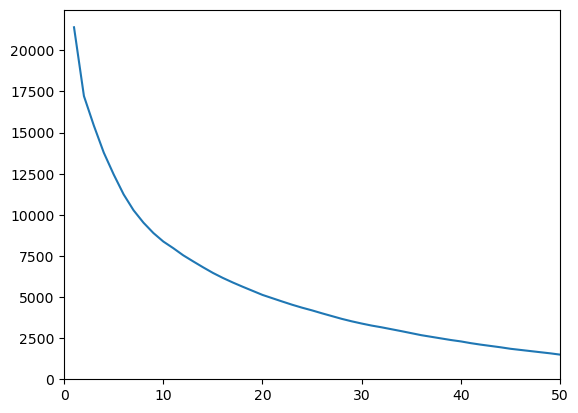

In [201]:
plt.plot(len(caselist_team_data) - np.cumsum(caselist_data.teamId.value_counts().value_counts().sort_index()))
plt.xlim(0, 50)
plt.ylim(0)

In [187]:
caselist_team_data.schoolId.value_counts().value_counts()

1     2683
2     1212
3      764
4      510
5      405
6      301
7      209
8      169
9      122
10     102
11      75
14      53
13      52
12      51
16      39
15      31
17      23
18      19
19      19
20      17
24      11
23      10
22       9
21       8
27       6
28       6
26       5
30       4
36       4
35       3
25       2
29       2
39       1
42       1
45       1
Name: schoolId, dtype: int64

In [34]:
tournament_counts = caselist_data.groupby('teamId').tournament.aggregate(lambda t: t.nunique())

1     25504
2     16884
3     12225
4      9579
5      7839
6      6412
7      5329
8      4362
9      3616
10     2944
11     2347
12     1879
13     1469
14     1144
15      902
16      695
17      531
18      403
19      284
20      220
21      163
22      105
23       77
24       66
25       44
26       31
27       20
28       16
29       14
30        8
31        4
35        3
47        2
50        1
Name: tournament, dtype: int64

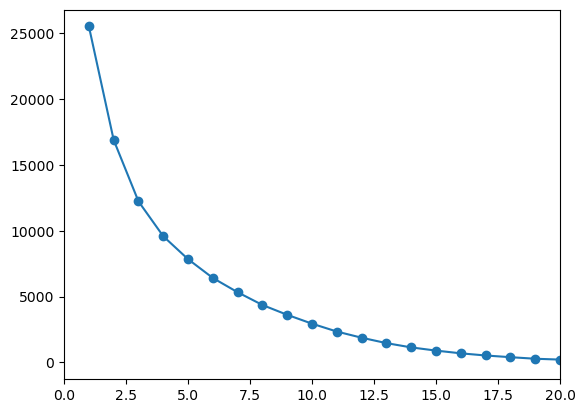

In [44]:
plt.xlim(0, 20)
plot_gte(tournament_counts)

In [49]:
caselist_data[caselist_data.fileName.notna()].teamId.nunique() / caselist_data.teamId.nunique()

0.4434990589711418

In [55]:
full_names = caselist_data.fileName.str.split('-').apply(lambda l: l[1:-3] if l else None)

In [54]:
caselist_data.apply()

0         None
1         None
2         None
3         None
4         None
          ... 
338516    None
338517    None
338518    None
338519    None
338520    None
Name: fileName, Length: 338521, dtype: object

## Analyze teams

In [ ]:
team_counts = Counter({k: len(v) for k, v in team_code_sets.items()})
team_counts.most_common(100)

In [20]:
team_codes: dict[int, set[str]] = {}
for code, teams in team_code_sets.items():
    for team_id in teams:
        if not team_id in team_codes: team_codes[team_id] = set()
        team_codes[team_id].add(code)

In [21]:
team_code_counts = Counter({team: len(codes) for team, codes in team_codes.items()})

In [ ]:
(np.array(list(team_code_counts.values())) ** 2).mean(), (np.array(list(team_counts.values())) ** 2).mean()